In [2]:
use_gpu = False

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
import sys
sys.path.insert(0, '..')
from image_generation import generate_price_image

if use_gpu:
    from utils.gpu_tools import *
    os.environ["CUDA_VISIBLE_DEVICES"] = ','.join([ str(obj) for obj in select_gpu(query_gpu())])

os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(42)

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}  

In [107]:
btc_ohlc = pd.read_csv('../btc_ohlc_a.csv')
data_window = 20
lookahead = 5
data_offset = len(btc_ohlc) - (data_window + lookahead)
images = []
labels = []
for i in tqdm(range(data_offset)):  # Ensuring there are at least 20 periods
    df_subset = btc_ohlc.iloc[i:i+data_window]      # Selecting 20 periods
    result = generate_price_image(df_subset, image_size=(64,60), show_volume=True)
    labels.append(btc_ohlc.iloc[i+data_window + lookahead])
    images.append(result)

  0%|          | 0/916 [00:00<?, ?it/s]

100%|██████████| 916/916 [00:18<00:00, 49.42it/s]


## load data

In [100]:
year_list = np.arange(2001,2020,1)

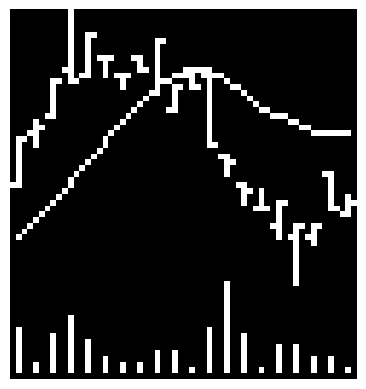

(916, 64, 60)
(916, 9)
          Date    Open    High     Low   Close      Volume    Ret_5d  \
25  2014-04-03  478.72  478.72  437.52  447.08  40765500.0 -0.299325   
26  2014-04-07  448.88  464.83  448.88  457.79   9802770.0 -0.250311   
27  2014-04-11  450.46  450.46  360.84  420.06  62562800.0 -0.260171   
28  2014-04-15  420.66  520.12  414.95  520.12  49561000.0 -0.083715   
29  2014-04-19  529.16  529.16  478.23  501.55  19588200.0  0.096524   

     Ret_20d        ma  
25 -0.480405   660.899  
26 -0.453822    641.88  
27 -0.504044  620.5345  
28 -0.416814  601.9475  
29 -0.386806  586.1285  


In [110]:
# images = []
label_df = pd.concat(labels, axis=1).T
images = np.array(images).reshape((-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
def display_image(image):
    plt.axis('off')  # Hide the axes
    plt.imshow(image, cmap='gray')
    plt.show()
    pass

display_image(images[0])
print(images.shape)
print(label_df.shape)
print(label_df.head())

## build dataset

In [111]:
class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

In [112]:
dataset = MyDataset(images, (label_df.Ret_20d > 0).values)

In [113]:
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

# the neural network

In [114]:
net_path = '../pt/20231110_003032/baseline_epoch_5_train_0.694151_val_0.696329.pt'

In [115]:
from models import baseline
device = 'cuda' if use_gpu else 'cpu'

In [116]:
net = torch.load(net_path)


## test

In [117]:
def eval_loop(dataloader, net, loss_fn):
    
    running_loss = 0.0
    total_loss = 0.0
    current = 0
    net.eval()
    target = []
    predict = []
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y.long())
                
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                current += len(X)
                t.set_postfix({'running_loss':running_loss})
            
    return total_loss, torch.cat(predict), torch.cat(target)

In [118]:
loss_fn = nn.CrossEntropyLoss()
test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn)

predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:,1]).cpu().numpy()

100%|██████████| 1/1 [00:02<00:00,  2.45s/it, running_loss=0.714]


## Plot the performance

[0.43775138 0.44128755 0.49194464 0.47737196 0.4852405  0.49398732
 0.5313076  0.5063312  0.54406714 0.5451526  0.4926577  0.48429337
 0.40746924 0.48974812 0.5213981  0.47975427 0.50624514 0.4610457
 0.45296517 0.51119417 0.50063396 0.55303043 0.45590082 0.52039415
 0.5167299  0.5072582  0.5112713  0.5471026  0.46271688 0.5032491
 0.50945115 0.48109588 0.4709433  0.5576203  0.537492   0.5037206
 0.5814648  0.54389924 0.62416756 0.54809195 0.5577746  0.62435716
 0.6525758  0.5584434  0.5276101  0.6002918  0.5706873  0.5011251
 0.45597893 0.5022356  0.5600751  0.56973445 0.5270806  0.5011549
 0.5568516  0.5439124  0.55888397 0.4760133  0.48799494 0.58977073
 0.5532096  0.5072382  0.50398636 0.51291573 0.5548309  0.5173913
 0.5320624  0.52112305 0.5305405  0.52092236 0.54025    0.5335118
 0.5294492  0.5265633  0.5578255  0.56554544 0.5655701  0.57998335
 0.589763   0.5811934  0.533156   0.5262043  0.5616757  0.509608
 0.5168444  0.4877212  0.5439163  0.5470687  0.46293333 0.49695137
 0.5

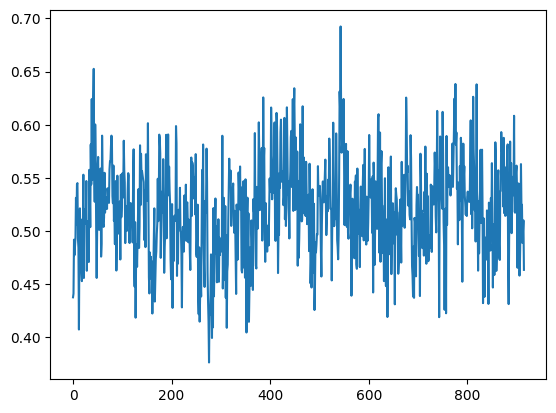

In [119]:
from matplotlib import pyplot as plt
print(predict_logit)
plt.plot(predict_logit)

### Same Weighted

In [206]:
threshold = 0.

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_5d
label_filtered = label_df[predict_logit>threshold]
ret_baseline = label_filtered .groupby(['Date'])['Ret_5d'].mean()


upper_threshold = 0.57
lower_threshold = 0.49

label_df['ret_baseline'] = label_df['Ret_5d']
label_df['predict_logit'] = predict_logit
label_df['ret'] = np.where(predict_logit > upper_threshold, label_df['Ret_5d'], label_df['ret'])
label_df['ret'] = np.where(predict_logit < lower_threshold, -label_df['Ret_5d'], label_df['ret'])
label_df['ret'] = np.where((predict_logit > lower_threshold) & (predict_logit < upper_threshold), label_df['Ret_5d'], 0)
label_filtered = label_df
ret_baseline = label_df.groupby('Date')['ret_baseline'].mean()
ret_cnn = label_df.groupby('Date')['ret'].mean()


print(f'label df\n {label_df.head()}')
print(f'label filtered\n {len(label_filtered)}')
print(f'ret baseline vs ret cnn\n {ret_baseline.sum()} vs {ret_cnn.sum()}')
print(f'len ret baseline vs len ret cnn\n {len(ret_baseline)} vs {len(ret_cnn)}')
# threshold = 0.50
# label_df['ret'] = (predict_logit>threshold) * label_df.Ret_5d
# label_filtered = label_df[predict_logit>threshold]
# ret_cnn = label_filtered .groupby(['Date'])['Ret_5d'].mean()


label df
           Date    Open    High     Low   Close      Volume    Ret_5d  \
25  2014-04-03  478.72  478.72  437.52  447.08  40765500.0 -0.299325   
26  2014-04-07  448.88  464.83  448.88  457.79   9802770.0 -0.250311   
27  2014-04-11  450.46  450.46  360.84  420.06  62562800.0 -0.260171   
28  2014-04-15  420.66  520.12  414.95  520.12  49561000.0 -0.083715   
29  2014-04-19  529.16  529.16  478.23  501.55  19588200.0  0.096524   

     Ret_20d        ma       ret ret_baseline  predict_logit  
25 -0.480405   660.899         0    -0.299325       0.437751  
26 -0.453822    641.88         0    -0.250311       0.441288  
27 -0.504044  620.5345 -0.260171    -0.260171       0.491945  
28 -0.416814  601.9475         0    -0.083715       0.477372  
29 -0.386806  586.1285         0     0.096524       0.485240  
label filtered
 916
ret baseline vs ret cnn
 35.11109969571991 vs 21.246673325824567
len ret baseline vs len ret cnn
 916 vs 916


#### number of stocks selected by time

In [183]:
# plt.scatter(label_filtered.groupby(['Date'])['ret'].count().index, label_filtered.groupby(['Date'])['ret'].count(),marker='+')

### Compare of log accumulate return

C:\Users\shoge\AppData\Local\Temp\ipykernel_30836\2798991547.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
C:\Users\shoge\AppData\Local\Temp\ipykernel_30836\2798991547.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))


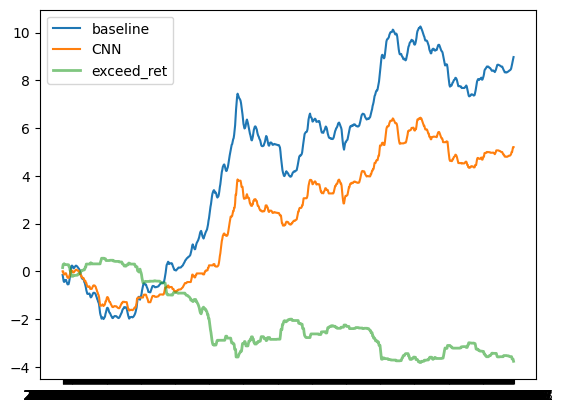

In [205]:
log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))
fig = plt.figure()
plt.plot(log_ret_baseline, label='baseline')
plt.plot(log_ret_cnn, label='CNN')
plt.plot(log_ret_cnn - log_ret_baseline, alpha=0.6, lw=2, label='exceed_ret')
plt.legend()
plt.show()
# fig.savefig('../pic/performance1.png',dpi=300)


In [127]:
import pandas as pd
import numpy as np

def analyze_performance(return_streams):
    results = {}

    for strategy, returns in return_streams.items():
        # Ensure the returns are a Pandas Series
        if not isinstance(returns, pd.Series):
            returns = pd.Series(returns)

        # Calculations
        # Sharpe Ratio
        sharpe_ratio = returns.mean() / returns.std()

        # Max Drawdown
        rolling_max = returns.cummax()
        drawdown = (returns - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        # Sortino Ratio
        target_return = 0
        downside_returns = returns[returns < target_return]
        sortino_ratio = (returns.mean() - target_return) / downside_returns.std()

        # Turnover (Assuming we need additional data like portfolio holdings)
        # turnover = ... (This metric typically requires holdings data)

        # Additional Metrics (like Alpha, Beta, Annualized Return, Volatility)
        # Assuming a risk-free rate of 0 for simplicity
        annualized_return = (1 + returns.mean()) ** 252 - 1  # 252 trading days
        volatility = returns.std() * np.sqrt(252)

        # Compile the results
        results[strategy] = {
            "Sharpe Ratio": sharpe_ratio,
            "Max Drawdown": max_drawdown,
            "Sortino Ratio": sortino_ratio,
            "Annualized Return": annualized_return,
            "Volatility": volatility
        }

    return pd.DataFrame(results)

# Example usage
return_streams = {
    "CNN 1": ret_cnn,  # Replace with actual returns
    "Baseline 2": ret_baseline   # Replace with actual returns
}

analyze_performance(return_streams)


,CNN 1,Baseline 2
Sharpe Ratio,0.169682,0.206287
Max Drawdown,-3.787816,-2.714804
Sortino Ratio,0.341065,0.434034
Annualized Return,2319.214706,13079.237876
Volatility,2.921639,2.949694


C:\Users\shoge\AppData\Local\Temp\ipykernel_30836\3359981319.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  plt.plot((ret_cnn+1).cumprod().fillna(method='ffill'), label='CNN_accumulate_ret')


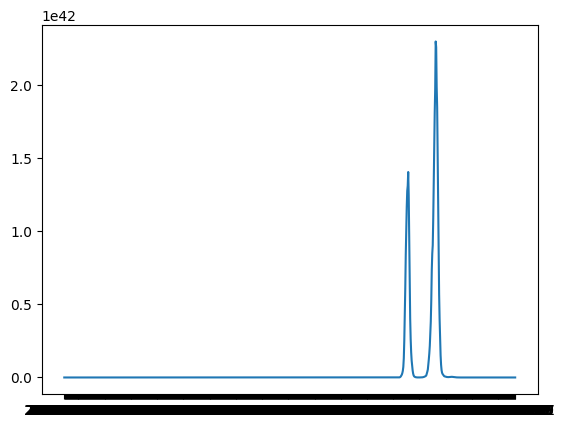

In [64]:
plt.plot((ret_cnn+1).cumprod().fillna(method='ffill'), label='CNN_accumulate_ret')
plt.savefig('../pic/performance2.png',dpi=300)

## Weighted by EWMA_Vol

In [313]:
label_df['weighted_ret'] = 1 * label_df.Ret_20d * label_df['EWMA_vol']
label_df['weight'] = 1 * label_df['EWMA_vol']
ret_baseline = label_df.groupby(['Date'])['weighted_ret'].sum()/(label_df.groupby(['Date'])['weight'].sum())

threshold = 0.58

label_df['weighted_ret'] = (predict_logit>threshold) * label_df.Ret_20d * label_df['EWMA_vol']
label_df['weight'] = (predict_logit>threshold) * label_df['EWMA_vol']
ret_cnn = label_df.groupby(['Date'])['weighted_ret'].sum()/(label_df.groupby(['Date'])['weight'].sum())

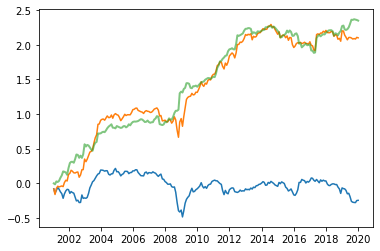

In [314]:
log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))
plt.plot(log_ret_baseline)
plt.plot(log_ret_cnn)
plt.plot(log_ret_cnn - log_ret_baseline, alpha=0.6, lw=2)